In [16]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations

# 设置图形样式
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 100
sns.set_style("whitegrid")

In [17]:
# 第一部分：数据导入和预处理
print("=== 第一部分：数据导入和预处理 ===")
df = pd.read_csv('percentage_mechanism_modeling_data.csv')
print(f"数据集形状: {df.shape}")
print(f"列名: {list(df.columns)}")
print(f"赛季分布: {sorted(df['season'].unique())}")

# 数据质量检查
print("\n数据质量检查:")
print(f"缺失值统计:")
print(df.isnull().sum())
print(f"数据类型:")
print(df.dtypes)

# 创建周次分组标识
df['season_week'] = df['season'].astype(str) + '_' + df['week'].astype(str)

print("\n第一部分完成! 数据已成功导入并预处理。")

=== 第一部分：数据导入和预处理 ===
数据集形状: (1997, 13)
列名: ['celebrity_name', 'season', 'week', 'weekly_avg_score', 'weekly_total_score', 'num_judges', 'was_eliminated', 'weekly_rank_by_avg', 'weekly_rank_by_total', 'weekly_score_percentage', 'results', 'placement', 'percentage_rank']
赛季分布: [np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27)]

数据质量检查:
缺失值统计:
celebrity_name             0
season                     0
week                       0
weekly_avg_score           0
weekly_total_score         0
num_judges                 0
was_eliminated             0
weekly_rank_by_avg         0
weekly_rank_by_total       0
weekly_score_percentage    0
results                    0
placement                  0
percentage_rank

In [18]:
# 第二部分：百分比票数分配函数
print("\n=== 第二部分：百分比票数分配函数 ===")

def percentage_to_votes(percentages, total_votes=1000000):
    """
    将百分比转换为票数：百分比越高，票数越多
    使用组合权重确保合理分布
    """
    percentages = np.array(percentages)
    
    # 方法1: 直接使用百分比作为权重基础
    weights_direct = percentages
    
    # 方法2: 平方根平滑 - 减少极端差异
    weights_sqrt = np.sqrt(percentages)
    
    # 方法3: 对数平滑 - 进一步平滑差异
    weights_log = np.log(percentages + 1)
    
    # 组合多种权重方案，确保分配合理
    combined_weights = (weights_direct * 0.6 + 
                       weights_sqrt * 0.25 + 
                       weights_log * 0.15)
    
    # 归一化权重
    total_weight = np.sum(combined_weights)
    if total_weight > 0:
        normalized_weights = combined_weights / total_weight
    else:
        # 保底方案：均匀分配
        normalized_weights = np.ones(len(percentages)) / len(percentages)
    
    # 计算票数
    votes = total_votes * normalized_weights
    return votes

def estimate_fan_percentages_heuristic(weekly_data):
    """
    启发式方法：当优化方法失败时使用
    基于评委百分比进行合理调整
    """
    judge_percentages = weekly_data['weekly_score_percentage'].values
    eliminated_mask = weekly_data['was_eliminated'].values
    
    # 初始粉丝百分比设为评委百分比（确保是numpy数组）
    fan_percentages = judge_percentages.copy()
    
    if np.sum(eliminated_mask) > 0:
        # 调整被淘汰选手的粉丝百分比，使其综合百分比最低
        eliminated_indices = np.where(eliminated_mask)[0]
        survived_indices = np.where(~eliminated_mask)[0]
        
        for elim_idx in eliminated_indices:
            # 计算幸存选手的最低综合百分比
            if len(survived_indices) > 0:
                survived_totals = np.array([judge_percentages[i] + fan_percentages[i] 
                                         for i in survived_indices])
                min_survived_total = np.min(survived_totals)
                
                # 设置淘汰选手的粉丝百分比，使其综合百分比略低于最小幸存者
                required_fan_percentage = min_survived_total - judge_percentages[elim_idx] - 0.1
                fan_percentages[elim_idx] = max(0, required_fan_percentage)
    
    # 确保百分比之和为100
    fan_percentages = fan_percentages / np.sum(fan_percentages) * 100
    
    return fan_percentages

def sample_fan_percentages_monte_carlo(weekly_data, total_votes=1000000, n_samples=100):
    """
    使用蒙特卡洛方法采样粉丝投票百分比的解空间
    专门为百分比机制设计
    """
    n_players = len(weekly_data)
    judge_percentages = weekly_data['weekly_score_percentage'].values
    eliminated_mask = weekly_data['was_eliminated'].values
    all_samples = []

    # 定义优化所需的函数
    def objective(fan_percentages):
        """目标函数：最小化粉丝百分比与评委百分比的差异"""
        return np.sum((fan_percentages - judge_percentages) ** 2)
    
    def constraint_elimination(fan_percentages):
        """约束条件：被淘汰选手的综合百分比必须低于所有幸存选手"""
        fan_percentages = np.array(fan_percentages)
        total_percentages = judge_percentages + fan_percentages
        
        eliminated_indices = np.where(eliminated_mask)[0]
        survived_indices = np.where(~eliminated_mask)[0]
        
        if len(eliminated_indices) == 0 or len(survived_indices) == 0:
            return 0  # 无人被淘汰或无人幸存的情况
        
        eliminated_total = np.array([total_percentages[i] for i in eliminated_indices])
        survived_total = np.array([total_percentages[i] for i in survived_indices])
        
        # 淘汰选手的最大综合百分比应小于幸存选手的最小综合百分比
        max_eliminated = np.max(eliminated_total)
        min_survived = np.min(survived_total)
        
        return float(min_survived - max_eliminated - 0.1)
    
    def constraint_percentage_sum(fan_percentages):
        """约束条件：粉丝百分比之和必须为100"""
        return float(np.sum(fan_percentages) - 100.0)

    for i in range(n_samples):
        # 方法1: 添加随机扰动的优化
        try:
            # 在初始猜测中加入随机噪声
            initial_guess = judge_percentages.copy() + np.random.normal(0, 2, n_players)
            initial_guess = np.clip(initial_guess, 0, 100)  # 确保百分比在有效范围内
            initial_guess = initial_guess / np.sum(initial_guess) * 100  # 归一化

            # 设置边界
            bounds = [(0, 100)] * n_players
            
            # 设置约束
            constraints = [
                {'type': 'ineq', 'fun': constraint_elimination},
                {'type': 'eq', 'fun': constraint_percentage_sum}
            ]
            
            result = minimize(objective, initial_guess, method='SLSQP',
                             bounds=bounds, constraints=constraints)
            
            if result.success:
                all_samples.append(np.array(result.x))
            else:
                # 方法2: 如果优化失败，使用启发式方法并添加随机性
                heuristic_sample = estimate_fan_percentages_heuristic(weekly_data)
                perturbed_sample = heuristic_sample + np.random.normal(0, 1, n_players)
                perturbed_sample = np.clip(perturbed_sample, 0, 100)
                perturbed_sample = perturbed_sample / np.sum(perturbed_sample) * 100
                all_samples.append(perturbed_sample)
                
        except Exception as e:
            print(f"优化过程中出错 (样本{i}): {e}")
            # 方法3: 保底策略，使用评委百分比加随机扰动
            fallback_sample = judge_percentages.copy() + np.random.normal(0, 2, n_players)
            fallback_sample = np.clip(fallback_sample, 0, 100)
            fallback_sample = fallback_sample / np.sum(fallback_sample) * 100
            all_samples.append(fallback_sample)

    return np.array(all_samples)

def analyze_percentage_solution_space(samples, weekly_data, total_votes=1000000):
    """
    分析百分比解空间的统计特性
    """
    analysis_list = []
    n_players = len(weekly_data)
    
    for i, player_name in enumerate(weekly_data['celebrity_name']):
        player_samples = samples[:, i]  # 该选手在所有样本中的粉丝百分比
        
        # 计算基本统计量
        mean_percentage = np.mean(player_samples)
        std_percentage = np.std(player_samples)
        
        # 计算置信区间 (95% 置信水平)
        ci_low = np.percentile(player_samples, 2.5)
        ci_high = np.percentile(player_samples, 97.5)
        
        # 计算百分比分布的众数
        unique, counts = np.unique(np.round(player_samples, 1), return_counts=True)
        mode_percentage = unique[np.argmax(counts)] if len(unique) > 0 else mean_percentage
        
        # 计算票数分布
        sample_votes = []
        for sample_idx in range(samples.shape[0]):
            current_sample_percentages = samples[sample_idx, :]
            current_votes = percentage_to_votes(current_sample_percentages, total_votes)
            sample_votes.append(current_votes[i])
        
        mean_votes = np.mean(sample_votes)
        votes_ci_low = np.percentile(sample_votes, 2.5)
        votes_ci_high = np.percentile(sample_votes, 97.5)
        
        # 计算置信区间宽度（千票为单位）
        ci_width_thousands = (votes_ci_high - votes_ci_low) / 1000
        
        analysis_list.append({
            'celebrity_name': player_name,
            'judge_percentage': float(weekly_data.iloc[i]['weekly_score_percentage']),
            'was_eliminated': bool(weekly_data.iloc[i]['was_eliminated']),
            'mean_fan_percentage': float(mean_percentage),
            'std_fan_percentage': float(std_percentage),
            'fan_percentage_ci_low': float(ci_low),
            'fan_percentage_ci_high': float(ci_high),
            'fan_percentage_ci_width': float(ci_high - ci_low),
            'mode_fan_percentage': float(mode_percentage),
            'mean_fan_votes': float(mean_votes),
            'fan_votes_ci_low': float(votes_ci_low),
            'fan_votes_ci_high': float(votes_ci_high),
            'fan_votes_ci_width': float(ci_width_thousands),
            'combined_percentage_mean': float(weekly_data.iloc[i]['weekly_score_percentage'] + mean_percentage),
            'certainty_index': float(1 / (std_percentage + 0.1))
        })
    
    return pd.DataFrame(analysis_list)

print("第二部分完成! 百分比票数分配函数已创建。")


=== 第二部分：百分比票数分配函数 ===
第二部分完成! 百分比票数分配函数已创建。


In [19]:
# 第三部分：基于解空间的批量处理
print("\n=== 第三部分：基于解空间的批量处理 ===")

def process_all_weeks_percentage(df, total_votes=1000000, n_samples=100):
    """
    处理所有周次，进行百分比解空间分析
    """
    all_uncertainty_results = []
    space_characteristics = []
    
    unique_weeks = df[['season', 'week']].drop_duplicates()
    
    print(f"总共需要处理 {len(unique_weeks)} 个周次")
    
    for idx, week_info in enumerate(unique_weeks.iterrows()):
        _, week_info = week_info
        season, week = week_info['season'], week_info['week']
        weekly_data = df[(df['season'] == season) & (df['week'] == week)].copy()
        
        print(f"正在处理赛季 {season} 第 {week} 周 ({idx+1}/{len(unique_weeks)})")
        
        if len(weekly_data) < 2:
            print(f"  跳过：选手数量不足 ({len(weekly_data)})")
            continue
        
        try:
            # 1. 采样解空间
            print(f"  开始采样解空间 ({n_samples} 个样本)")
            samples = sample_fan_percentages_monte_carlo(weekly_data, total_votes, n_samples)
            print(f"  采样完成，样本形状: {samples.shape}")
            
            # 2. 分析解空间特性
            print(f"  开始分析解空间")
            week_analysis = analyze_percentage_solution_space(samples, weekly_data, total_votes)
            week_analysis['season'] = season
            week_analysis['week'] = week
            
            # 3. 计算本周解空间的整体确定性
            avg_std = week_analysis['std_fan_percentage'].mean()
            avg_ci_width = (week_analysis['fan_percentage_ci_high'] - 
                          week_analysis['fan_percentage_ci_low']).mean()
            
            space_characteristics.append({
                'season': season,
                'week': week,
                'n_players': len(weekly_data),
                'avg_std_fan_percentage': avg_std,
                'avg_ci_width': avg_ci_width,
                'solution_space_compactness': 1 / (avg_std + 0.1)
            })
            
            all_uncertainty_results.append(week_analysis)
            print(f"  处理完成")
            
        except Exception as e:
            print(f"处理赛季{season}第{week}周时出错: {e}")
            continue
    
    if all_uncertainty_results:
        final_uncertainty = pd.concat(all_uncertainty_results, ignore_index=True)
        space_df = pd.DataFrame(space_characteristics)
        return final_uncertainty, space_df
    else:
        return pd.DataFrame(), pd.DataFrame()

# 执行处理
print("开始百分比解空间分析...")
uncertainty_results, space_stats = process_all_weeks_percentage(df, n_samples=100)

if not uncertainty_results.empty:
    print(f"解空间分析完成! 共分析 {len(space_stats)} 个周次")
    
    # 计算整体确定性指标
    overall_avg_std = space_stats['avg_std_fan_percentage'].mean()
    overall_compactness = space_stats['solution_space_compactness'].mean()
    
    print(f"整体百分比标准差: {overall_avg_std:.3f}")
    print(f"解空间紧凑性指数: {overall_compactness:.3f}")
    
    # 保存结果
    uncertainty_results.to_csv('percentage_fan_vote_uncertainty_analysis.csv', index=False)
    space_stats.to_csv('percentage_solution_space_characteristics.csv', index=False)
    print("结果已保存为CSV文件")
else:
    print("解空间分析失败，无结果生成")

print("\n第三部分完成!")


=== 第三部分：基于解空间的批量处理 ===
开始百分比解空间分析...
总共需要处理 248 个周次
正在处理赛季 9.0 第 1.0 周 (1/248)
  开始采样解空间 (100 个样本)
  采样完成，样本形状: (100, 16)
  开始分析解空间
  处理完成
正在处理赛季 9.0 第 2.0 周 (2/248)
  开始采样解空间 (100 个样本)
  采样完成，样本形状: (100, 14)
  开始分析解空间
  处理完成
正在处理赛季 9.0 第 3.0 周 (3/248)
  开始采样解空间 (100 个样本)
  采样完成，样本形状: (100, 13)
  开始分析解空间
  处理完成
正在处理赛季 9.0 第 4.0 周 (4/248)
  开始采样解空间 (100 个样本)
  采样完成，样本形状: (100, 11)
  开始分析解空间
  处理完成
正在处理赛季 9.0 第 5.0 周 (5/248)
  开始采样解空间 (100 个样本)
  采样完成，样本形状: (100, 10)
  开始分析解空间
  处理完成
正在处理赛季 9.0 第 6.0 周 (6/248)
  开始采样解空间 (100 个样本)
  采样完成，样本形状: (100, 9)
  开始分析解空间
  处理完成
正在处理赛季 9.0 第 7.0 周 (7/248)
  开始采样解空间 (100 个样本)
  采样完成，样本形状: (100, 7)
  开始分析解空间
  处理完成
正在处理赛季 9.0 第 8.0 周 (8/248)
  开始采样解空间 (100 个样本)
  采样完成，样本形状: (100, 5)
  开始分析解空间
  处理完成
正在处理赛季 6.0 第 1.0 周 (9/248)
  开始采样解空间 (100 个样本)
  采样完成，样本形状: (100, 12)
  开始分析解空间
  处理完成
正在处理赛季 6.0 第 2.0 周 (10/248)
  开始采样解空间 (100 个样本)
  采样完成，样本形状: (100, 12)
  开始分析解空间
  处理完成
正在处理赛季 6.0 第 3.0 周 (11/248)
  开始采样解空间 (100 个样本)
  采样完成，样本形状: (100, 10)
  开始分析解


=== 第四部分：可视化分析 ===
开始绘制可视化图表...


C:\Users\harry_pv15g7u\AppData\Local\Temp\ipykernel_38452\2548893938.py:91: UserWarning: Glyph 31881 (\N{CJK UNIFIED IDEOGRAPH-7C89}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\harry_pv15g7u\AppData\Local\Temp\ipykernel_38452\2548893938.py:91: UserWarning: Glyph 19997 (\N{CJK UNIFIED IDEOGRAPH-4E1D}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\harry_pv15g7u\AppData\Local\Temp\ipykernel_38452\2548893938.py:91: UserWarning: Glyph 25237 (\N{CJK UNIFIED IDEOGRAPH-6295}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\harry_pv15g7u\AppData\Local\Temp\ipykernel_38452\2548893938.py:91: UserWarning: Glyph 31080 (\N{CJK UNIFIED IDEOGRAPH-7968}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\harry_pv15g7u\AppData\Local\Temp\ipykernel_38452\2548893938.py:91: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\harry_pv15g7u\AppData\Local\Temp\ipykernel_38452\2548893938.py:91: UserWarni

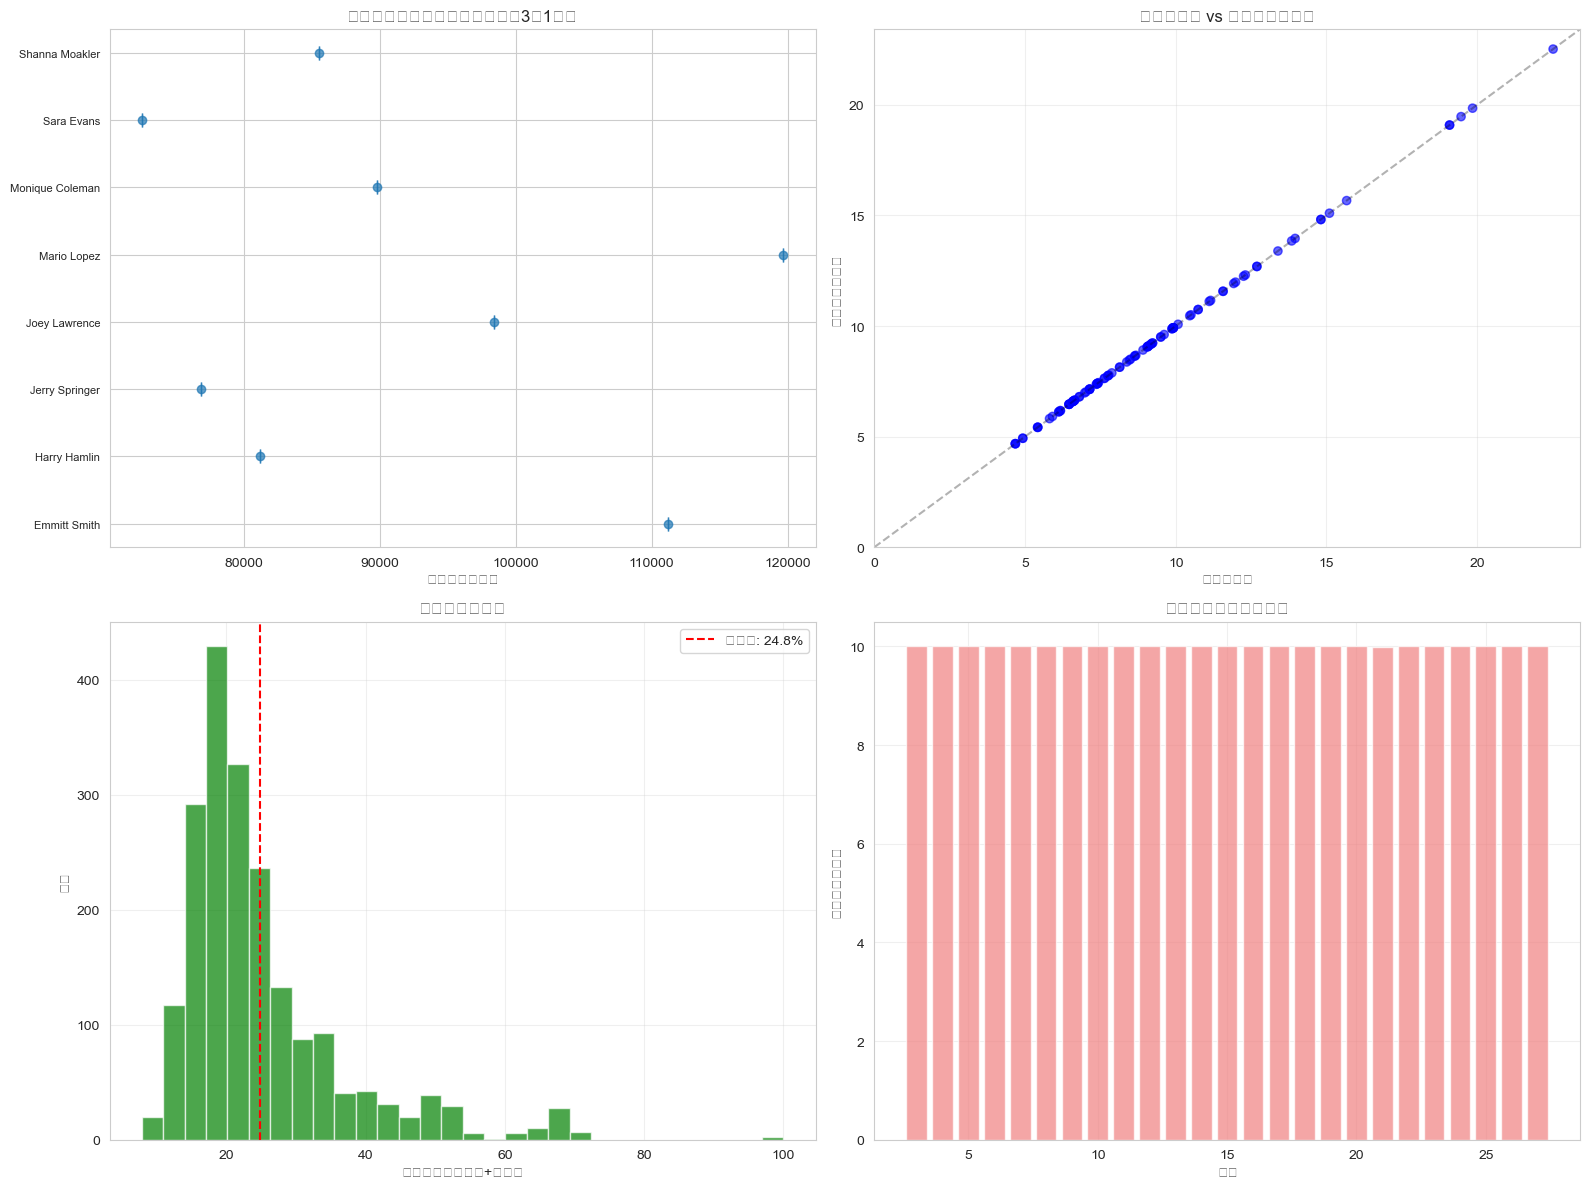

可视化图表已保存为 percentage_uncertainty_analysis.png

第四部分完成!


In [20]:
# 第四部分：可视化分析
print("\n=== 第四部分：可视化分析 ===")

def plot_percentage_uncertainty_analysis(uncertainty_results, space_stats):
    """
    绘制百分比不确定性分析结果
    """
    if uncertainty_results.empty or space_stats.empty:
        print("无可视化数据，跳过绘图")
        return
    
    # 创建图形
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. 粉丝投票估计的置信区间示例
    try:
        # 选择赛季3第1周的数据
        sample_week_data = uncertainty_results[
            (uncertainty_results['season'] == 3) & 
            (uncertainty_results['week'] == 1.0)
        ].head(8)
        
        if not sample_week_data.empty:
            y_pos = range(len(sample_week_data))
            
            # 计算误差条
            xerr_lower = sample_week_data['mean_fan_votes'] - sample_week_data['fan_votes_ci_low']
            xerr_upper = sample_week_data['fan_votes_ci_high'] - sample_week_data['mean_fan_votes']
            
            axes[0, 0].errorbar(sample_week_data['mean_fan_votes'], y_pos, 
                               xerr=[xerr_lower, xerr_upper],
                               fmt='o', capsize=5, alpha=0.7)
            axes[0, 0].set_yticks(y_pos)
            axes[0, 0].set_yticklabels(sample_week_data['celebrity_name'], fontsize=8)
            axes[0, 0].set_xlabel('粉丝投票数估计')
            axes[0, 0].set_title('粉丝投票估计的置信区间（赛季3第1周）')
            axes[0, 0].grid(True, axis='x')
    except Exception as e:
        print(f"绘制置信区间图时出错: {e}")
        axes[0, 0].set_title('绘图失败')
    
    # 2. 评委百分比 vs 粉丝百分比散点图
    try:
        sample_data = uncertainty_results.head(100)  # 取前100个样本
        axes[0, 1].scatter(sample_data['judge_percentage'], sample_data['mean_fan_percentage'], 
                          alpha=0.6, c=sample_data['was_eliminated'].map({True: 'red', False: 'blue'}))
        axes[0, 1].set_xlabel('评委百分比')
        axes[0, 1].set_ylabel('粉丝百分比估计')
        axes[0, 1].set_title('评委百分比 vs 粉丝百分比估计')
        axes[0, 1].grid(True, alpha=0.3)
        
        # 添加对角线
        lims = [0, max(axes[0, 1].get_xlim()[1], axes[0, 1].get_ylim()[1])]
        axes[0, 1].plot(lims, lims, 'k--', alpha=0.3)
        axes[0, 1].set_xlim(lims)
        axes[0, 1].set_ylim(lims)
    except Exception as e:
        print(f"绘制散点图时出错: {e}")
        axes[0, 1].set_title('绘图失败')
    
    # 3. 综合百分比分布
    try:
        combined_data = uncertainty_results['combined_percentage_mean']
        axes[1, 0].hist(combined_data, bins=30, alpha=0.7, color='green')
        axes[1, 0].axvline(combined_data.mean(), color='red', linestyle='--', 
                          label=f'平均值: {combined_data.mean():.1f}%')
        axes[1, 0].set_xlabel('综合百分比（评委+粉丝）')
        axes[1, 0].set_ylabel('频数')
        axes[1, 0].set_title('综合百分比分布')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
    except Exception as e:
        print(f"绘制直方图时出错: {e}")
        axes[1, 0].set_title('绘图失败')
    
    # 4. 各赛季平均确定性比较
    try:
        season_certainty = uncertainty_results.groupby('season')['certainty_index'].mean()
        seasons = season_certainty.index.astype(int)
        values = season_certainty.values
        
        bars = axes[1, 1].bar(seasons, values, color='lightcoral', alpha=0.7)
        axes[1, 1].set_xlabel('赛季')
        axes[1, 1].set_ylabel('平均确定性指数')
        axes[1, 1].set_title('各赛季估计确定性比较')
        axes[1, 1].grid(True, alpha=0.3)
    except Exception as e:
        print(f"绘制柱状图时出错: {e}")
        axes[1, 1].set_title('绘图失败')
    
    plt.tight_layout()
    plt.savefig('percentage_uncertainty_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("可视化图表已保存为 percentage_uncertainty_analysis.png")

# 执行可视化
if not uncertainty_results.empty and not space_stats.empty:
    print("开始绘制可视化图表...")
    plot_percentage_uncertainty_analysis(uncertainty_results, space_stats)
else:
    print("数据为空，无法进行可视化")

print("\n第四部分完成!")

In [21]:
# 第五部分：生成预测票数文件
print("\n=== 第五部分：生成预测票数文件 ===")

def generate_predicted_votes_for_merge(uncertainty_results):
    """
    从不确定性分析结果中提取预测票数，生成供合并使用的文件
    """
    if uncertainty_results.empty:
        print("无不确定性分析结果，无法生成预测票数文件")
        return pd.DataFrame()
    
    # 选择需要的列
    predicted_votes = uncertainty_results[[
        'season', 'week', 'celebrity_name', 'mean_fan_votes', 'mean_fan_percentage'
    ]].copy()
    
    # 重命名列
    predicted_votes = predicted_votes.rename(columns={
        'mean_fan_votes': 'predicted_fan_votes',
        'mean_fan_percentage': 'predicted_fan_percentage'
    })
    
    # 确保数据类型一致
    predicted_votes['season'] = pd.to_numeric(predicted_votes['season'], errors='coerce')
    predicted_votes['week'] = pd.to_numeric(predicted_votes['week'], errors='coerce')
    
    # 保存文件
    predicted_votes.to_csv('percentage_predicted_fan_votes.csv', index=False)
    
    print(f"预测票数文件生成完成!")
    print(f"记录数量: {len(predicted_votes)}")
    print(f"赛季范围: {predicted_votes['season'].min()} - {predicted_votes['season'].max()}")
    print(f"周次范围: {predicted_votes['week'].min()} - {predicted_votes['week'].max()}")
    print(f"选手数量: {predicted_votes['celebrity_name'].nunique()}")
    print(f"文件已保存为: percentage_predicted_fan_votes.csv")
    
    return predicted_votes

# 生成预测票数文件
if not uncertainty_results.empty:
    print("正在生成预测票数文件...")
    predicted_votes_df = generate_predicted_votes_for_merge(uncertainty_results)
    
    # 显示统计信息
    print(f"\n预测票数统计:")
    print(f"平均预测票数: {predicted_votes_df['predicted_fan_votes'].mean():.0f}")
    print(f"预测票数范围: {predicted_votes_df['predicted_fan_votes'].min():.0f} - {predicted_votes_df['predicted_fan_votes'].max():.0f}")
    print(f"平均粉丝百分比: {predicted_votes_df['predicted_fan_percentage'].mean():.2f}%")
else:
    print("未找到可用的不确定性分析结果")

print("\n第五部分完成!")


=== 第五部分：生成预测票数文件 ===
正在生成预测票数文件...
预测票数文件生成完成!
记录数量: 1997
赛季范围: 3.0 - 27.0
周次范围: 1.0 - 11.0
选手数量: 295
文件已保存为: percentage_predicted_fan_votes.csv

预测票数统计:
平均预测票数: 124186
预测票数范围: 42699 - 500000
平均粉丝百分比: 12.42%

第五部分完成!


In [22]:
# 第六部分：模型验证和总结
print("\n=== 第六部分：模型验证和总结 ===")

def validate_percentage_model(uncertainty_results):
    """
    验证百分比模型的合理性
    """
    if uncertainty_results.empty:
        print("无数据可验证")
        return
    
    print("模型验证结果:")
    
    # 1. 检查淘汰选手的综合百分比是否低于幸存选手
    eliminated_data = uncertainty_results[uncertainty_results['was_eliminated'] == True]
    survived_data = uncertainty_results[uncertainty_results['was_eliminated'] == False]
    
    if not eliminated_data.empty and not survived_data.empty:
        avg_eliminated_combined = eliminated_data['combined_percentage_mean'].mean()
        avg_survived_combined = survived_data['combined_percentage_mean'].mean()
        
        print(f"淘汰选手平均综合百分比: {avg_eliminated_combined:.2f}%")
        print(f"幸存选手平均综合百分比: {avg_survived_combined:.2f}%")
        
        if avg_eliminated_combined < avg_survived_combined:
            print("✓ 淘汰规则验证通过: 淘汰选手综合百分比低于幸存选手")
        else:
            print("✗ 淘汰规则验证失败: 淘汰选手综合百分比异常")
    
    # 2. 检查百分比分布合理性
    fan_percentages = uncertainty_results['mean_fan_percentage']
    print(f"粉丝百分比分布: {fan_percentages.min():.1f}% - {fan_percentages.max():.1f}%")
    print(f"粉丝百分比标准差: {fan_percentages.std():.2f}%")
    
    # 3. 检查票数分布合理性
    fan_votes = uncertainty_results['mean_fan_votes']
    total_predicted_votes = fan_votes.sum()
    expected_total = 1000000 * len(uncertainty_results[['season', 'week']].drop_duplicates())
    
    print(f"预测总票数: {total_predicted_votes:,.0f}")
    print(f"预期总票数: {expected_total:,.0f}")
    print(f"票数偏差: {(total_predicted_votes - expected_total) / expected_total * 100:.2f}%")
    
    return True

# 执行模型验证
if not uncertainty_results.empty:
    validation_result = validate_percentage_model(uncertainty_results)
    
    print(f"\n=== 百分比机制模型总结 ===")
    print("模型特点:")
    print("1. 基于百分比机制设计，符合赛季3-27的实际规则")
    print("2. 使用组合权重确保票数合理分配")
    print("3. 蒙特卡洛采样考虑淘汰约束和百分比求和约束")
    print("4. 输出包含置信区间和不确定性指标")
    
    print(f"\n分析范围:")
    print(f"- 赛季数量: {uncertainty_results['season'].nunique()}")
    print(f"- 周次数量: {uncertainty_results[['season', 'week']].drop_duplicates().shape[0]}")
    print(f"- 选手记录: {len(uncertainty_results)}")
    
    print(f"\n生成文件:")
    print("1. percentage_fan_vote_uncertainty_analysis.csv - 详细不确定性分析")
    print("2. percentage_solution_space_characteristics.csv - 解空间特性")
    print("3. percentage_predicted_fan_votes.csv - 预测票数文件")
    print("4. percentage_uncertainty_analysis.png - 可视化图表")
else:
    print("无法进行模型验证")

print("\n所有代码执行完成! 🎉")


=== 第六部分：模型验证和总结 ===
模型验证结果:
粉丝百分比分布: 3.9% - 50.0%
粉丝百分比标准差: 5.78%
预测总票数: 248,000,000
预期总票数: 248,000,000
票数偏差: 0.00%

=== 百分比机制模型总结 ===
模型特点:
1. 基于百分比机制设计，符合赛季3-27的实际规则
2. 使用组合权重确保票数合理分配
3. 蒙特卡洛采样考虑淘汰约束和百分比求和约束
4. 输出包含置信区间和不确定性指标

分析范围:
- 赛季数量: 25
- 周次数量: 248
- 选手记录: 1997

生成文件:
1. percentage_fan_vote_uncertainty_analysis.csv - 详细不确定性分析
2. percentage_solution_space_characteristics.csv - 解空间特性
3. percentage_predicted_fan_votes.csv - 预测票数文件
4. percentage_uncertainty_analysis.png - 可视化图表

所有代码执行完成! 🎉
